In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())
print(tf.device('/device:GPU:0'))

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6352392504658868576
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4139778048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15249912501178432220
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
# base_url = "D:/downloads"
# image_path = "/jpeg/train"
# image_path1 = "/HAM10000_images_part_1"
base_url = "D:/"
image_path = "melanoma-data/siim-isic-melanoma-classification/jpeg/train"
image_path1 = "1"
import os
import pandas as pd
print(len(os.listdir(base_url + image_path)))
print(len(os.listdir(base_url + image_path1)))

33126
10015


In [3]:
import csv
import numpy as np
with open(base_url + '/train.csv') as file_name:
    file_read = csv.reader(file_name)
    array = list(file_read)
    np_arr = np.array(array)
print(np_arr[1:,[0,-1]])

with open(base_url + '/HAM10000_metadata.csv') as file_name:
    file_read = csv.reader(file_name)
    array = list(file_read)
    np_arr = np.array(array)
print(np_arr[1:,[1,2]])

[['ISIC_2637011' '0']
 ['ISIC_0015719' '0']
 ['ISIC_0052212' '0']
 ...
 ['ISIC_9999515' '0']
 ['ISIC_9999666' '0']
 ['ISIC_9999806' '0']]
[['ISIC_0027419' 'bkl']
 ['ISIC_0025030' 'bkl']
 ['ISIC_0026769' 'bkl']
 ...
 ['ISIC_0033536' 'akiec']
 ['ISIC_0032854' 'akiec']
 ['ISIC_0032258' 'mel']]


In [4]:
#read in train csv
train = pd.read_csv(base_url + 'train.csv')

#check for any missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

#fill missing anatom site values with "unknown or other"
train.anatom_site_general_challenge.fillna('other or unknown', inplace=True)

#drop all rows from the train dataframe that are associated with 3 patients who are missing some data.
train.drop(train[(train['patient_id'] == 'IP_0550106') | (train['patient_id'] == 'IP_5205991') |(train['patient_id'] == 'IP_9835712')].index, inplace=True)

#check for any more missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

data = train

n_pos = len(data[data['target']==1])
print('number of images in full train set: {}'.format(len(data)))
print('Number of positive images in subset of train set: {}'.format(n_pos))
print('Percentage of positive images in subset train set: {:.1%}'.format(n_pos/len(data)))
print('Number of negative images in subset train set: {}'.format(len(data) - n_pos))
print('Percentage of negative images in subset train set: {:.1%}'.format(1 - n_pos/len(data)))


image_name missing values: 0
patient_id missing values: 0
sex missing values: 65
age_approx missing values: 68
anatom_site_general_challenge missing values: 527
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0
image_name missing values: 0
patient_id missing values: 0
sex missing values: 0
age_approx missing values: 0
anatom_site_general_challenge missing values: 0
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0
number of images in full train set: 33058
Number of positive images in subset of train set: 584
Percentage of positive images in subset train set: 1.8%
Number of negative images in subset train set: 32474
Percentage of negative images in subset train set: 98.2%


In [5]:
#zmenime typ hodnoty s druheho datasetu na typ s prveho datasetu aby sme mohli potom dva datasety spojit
train1 = pd.read_csv(base_url + 'HAM10000_metadata.csv')
data1 = train1

malign_data1 = data1[data1['dx']=='mel'].to_numpy()[1:,[1,2]]
benign_data1 = data1[data1['dx']=='nv'].to_numpy()[1:,[1,2]]
#print(malign_data)
#print(benign_data)
#print(malign_data[1:,1])
#print(malign_data)
#print(malign_data[0][1])
malign_data1[0][1] = 1
benign_data1[0][1] = 0
for cislo in range(len(malign_data1[1:,1])):
    if malign_data1[1:,1][cislo-1] == 'mel':
        malign_data1[1:,1][cislo-1] = 1

for cislo in range(len(benign_data1[1:,1])):
    if benign_data1[1:,1][cislo] == 'nv':
        benign_data1[1:,1][cislo] = 0

print(malign_data1, '\n')
print(benign_data1)

[['ISIC_0030623' 1]
 ['ISIC_0027190' 1]
 ['ISIC_0031023' 1]
 ...
 ['ISIC_0032936' 1]
 ['ISIC_0033232' 1]
 ['ISIC_0032258' 1]] 

[['ISIC_0024693' 0]
 ['ISIC_0032212' 0]
 ['ISIC_0025775' 0]
 ...
 ['ISIC_0032221' 0]
 ['ISIC_0030693' 0]
 ['ISIC_0031649' 0]]


In [6]:
train = pd.read_csv(base_url + 'train.csv')
data = train
malign_data = data[data['target']==1].to_numpy()[1:,[0,-1]]
benign_data = data[data['target']==0].to_numpy()
# idx_x = np.random.choice(len(benign_data),int(len(benign_data)),replace=False)
# benign_data = np.array(benign_data[idx_x])


benign_data = benign_data[1:,[0,-1]]
print(len(benign_data))
print(len(malign_data))

for item in benign_data:
    item[0] = base_url + image_path + '/' + item[0]
for item in malign_data:
    item[0] = base_url + image_path + '/' + item[0]
for item in benign_data1:
    item[0] = base_url + image_path1 + '/' + item[0]
for item in malign_data1:
    item[0] = base_url + image_path1 + '/' + item[0]

benign_data = np.concatenate([benign_data, benign_data1])
malign_data = np.concatenate([malign_data, malign_data1])

# print(benign_data)
# print(malign_data)

# benign_data = benign_data[:1695]
#malign_data = malign_data[:1500]

print(len(benign_data))
print(len(malign_data))



#benign_data = benign_data.reshape(583 , 2) + benign_data1.reshape(6704, 2)
#malign_data = malign_data + malign_data1

#print(benign_data)
#print(malign_data)
#print(len(benign_data))
#print(len(malign_data))


32541
583
39245
1695


In [7]:
shuffle_benign = np.random.choice(len(benign_data),int(len(benign_data)),replace=False)
shuffle_malign = np.random.choice(len(malign_data),int(len(malign_data)),replace=False)
idx_train_benign = shuffle_benign[:int(len(shuffle_benign)*0.70)]
idx_test_benign = shuffle_benign[int(len(shuffle_benign)*0.70):int(len(shuffle_benign)*0.85)]
idx_valid_benign = shuffle_benign[int(len(shuffle_benign)*0.85):int(len(shuffle_benign)*1)]
idx_train_malign = shuffle_malign[:int(len(shuffle_malign)*0.70)]
idx_test_malign = shuffle_malign[int(len(shuffle_malign)*0.70):int(len(shuffle_benign)*0.85)]
idx_valid_malign = shuffle_malign[int(len(shuffle_malign)*0.85):int(len(shuffle_benign)*1)]

train_data_benign = benign_data[idx_train_benign]
test_data_benign = benign_data[idx_test_benign]
valid_data_benign = benign_data[idx_valid_benign]

train_data_malign = malign_data[idx_train_malign]
test_data_malign = malign_data[idx_test_malign]
valid_data_malign = malign_data[idx_valid_malign]
print(len(train_data_benign))
print(len(train_data_malign))
print(len(test_data_benign))
print(len(test_data_malign))
print(len(valid_data_benign))
print(len(valid_data_malign))

27471
1186
5887
509
5887
255


In [8]:
train_data = np.concatenate((train_data_benign, train_data_malign), axis=0)
test_data = np.concatenate((test_data_benign, test_data_malign), axis=0)
valid_data = np.concatenate((valid_data_benign, valid_data_malign), axis=0)

shuffle_train = np.random.choice(len(train_data),int(len(train_data)),replace=False)
shuffle_test = np.random.choice(len(test_data),int(len(test_data)),replace=False)
shuffle_valid = np.random.choice(len(valid_data),int(len(valid_data)),replace=False)

train_data = train_data[shuffle_train]
test_data = train_data[shuffle_test]
valid_data = train_data[shuffle_valid]
print(train_data)
print(test_data)
print(valid_data)

[['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_9119715'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_3274493'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_7672106'
  0]
 ...
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_6886237'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_5198201'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_8680421'
  0]]
[['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_6190245'
  0]
 ['D:/1/ISIC_0027380' 0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_5602053'
  0]
 ...
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_0822656'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_4261725'
  0]
 ['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_7788318'
  1]]
[['D:/melanoma-data/siim-isic-melanoma-

In [9]:
import cv2
import matplotlib.pyplot as plt

In [12]:
shapes = []
for img in train_data:
    shapes.append(np.shape(cv2.imread(img[0] + '.jpg')))
#print(shapes)

KeyboardInterrupt: 

In [14]:
df = pd.DataFrame(data = shapes)
df.hist()

NameError: name 'shapes' is not defined

In [10]:
import math

In [11]:
pd.DataFrame([x for x in train_data if x[1] == 1])

,0,1
0,D:/melanoma-data/siim-isic-melanoma-classifica...,1
1,D:/melanoma-data/siim-isic-melanoma-classifica...,1
2,D:/1/ISIC_0029558,1
3,D:/melanoma-data/siim-isic-melanoma-classifica...,1
4,D:/melanoma-data/siim-isic-melanoma-classifica...,1
...,...,...
1181,D:/1/ISIC_0034061,1
1182,D:/1/ISIC_0027673,1
1183,D:/melanoma-data/siim-isic-melanoma-classifica...,1
1184,D:/1/ISIC_0027436,1


In [11]:
import imgaug.augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

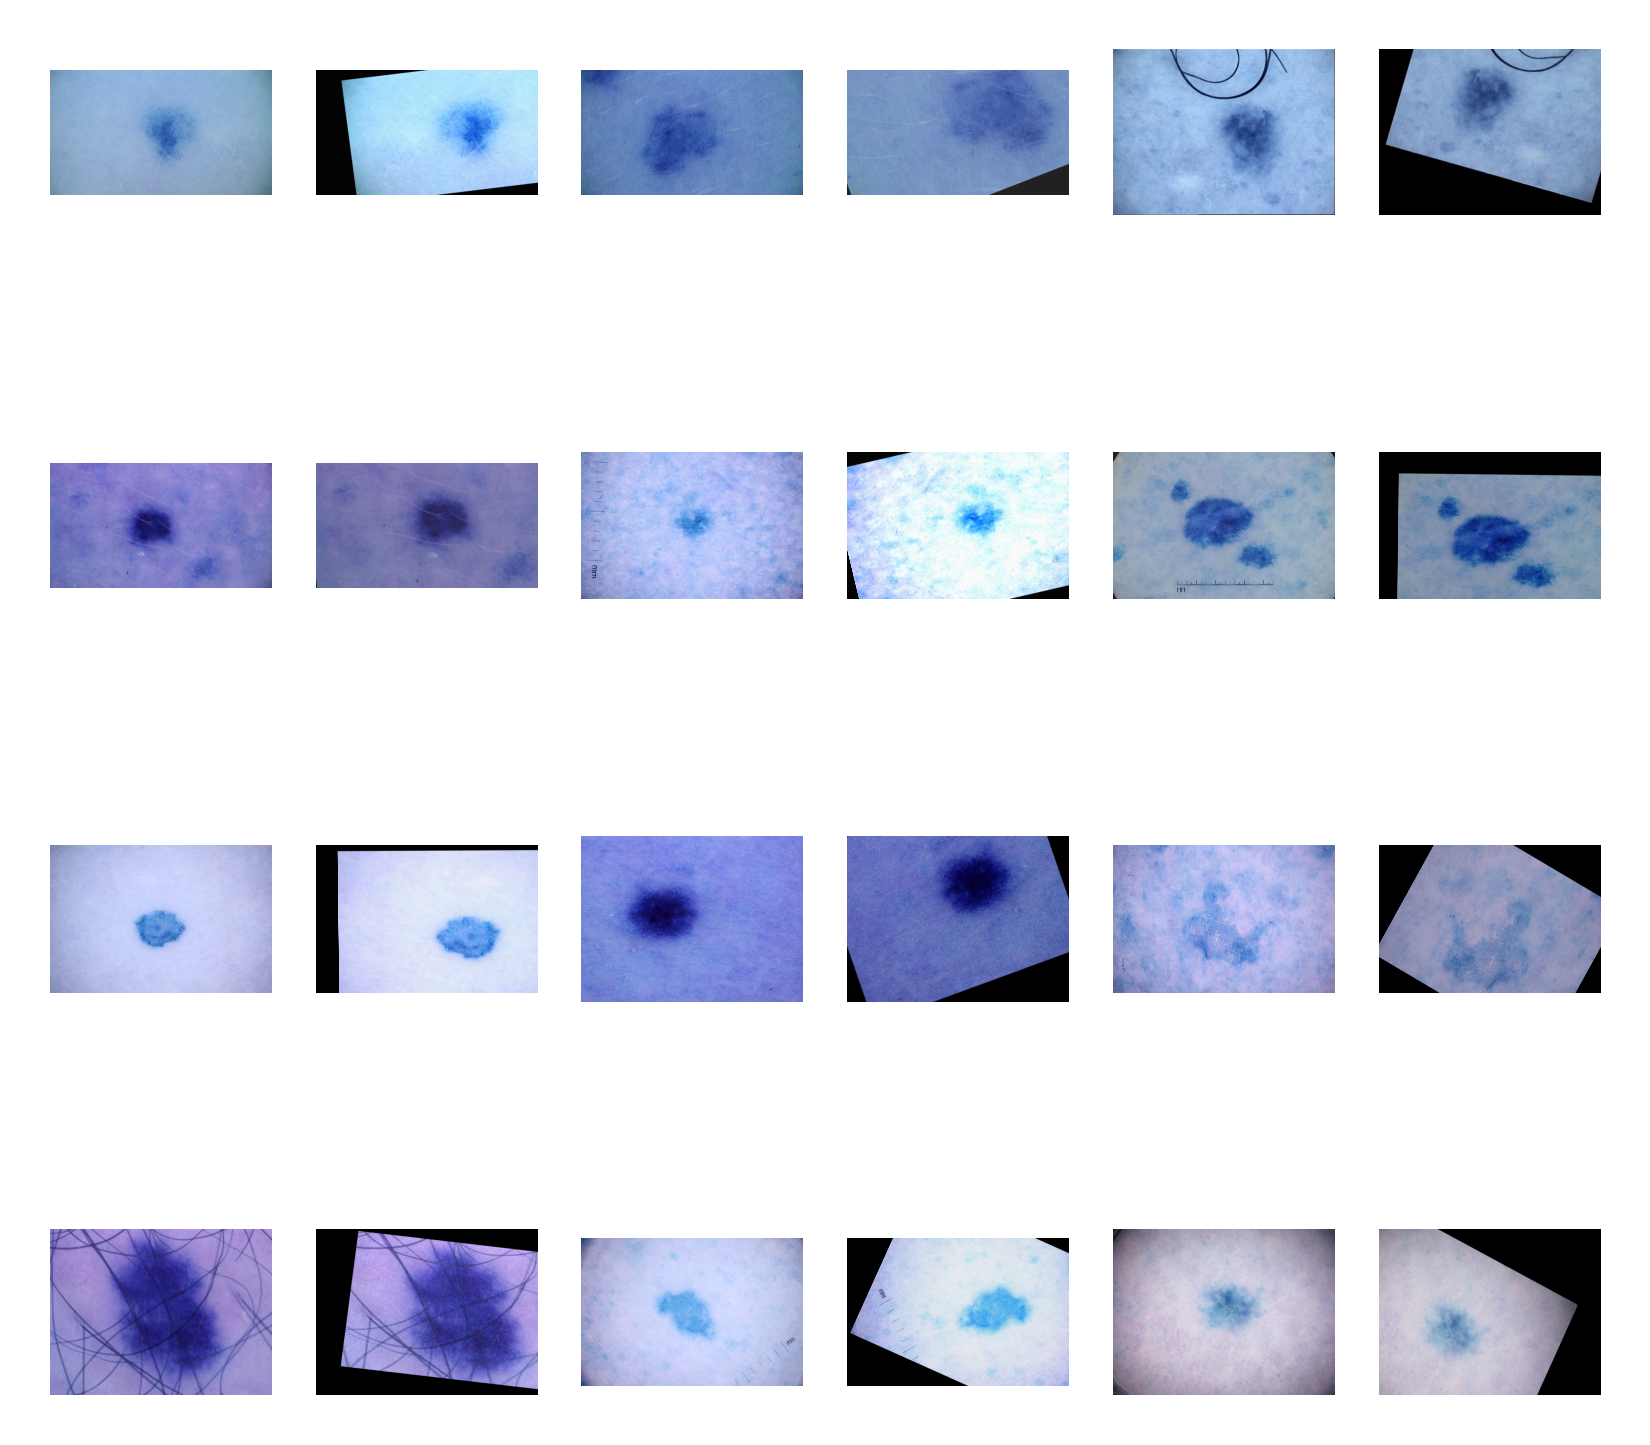

In [13]:
ind_x = 11
ind_y = 10
fig=plt.figure(figsize=(4,8), dpi= 500)
rows = 8
columns = 6
image = cv2.imread(train_data[1][0] + '.jpg')
for i in range(12):
    img_original = cv2.imread(train_data[i][0] + '.jpg')
    result = seq(images = [img_original])[0]
    fig.add_subplot(rows, columns, (2*(i+1)-1), label='original')
    plt.imshow(img_original)
    plt.axis('off')
    fig.add_subplot(rows, columns, (2*(i+1)), label='inverted')
    plt.imshow(result)
    plt.axis('off')

In [12]:
import math

In [13]:
class Generator(tf.keras.utils.Sequence ):

    def __init__(self, paths, labels, batch_size):
        self.paths, self.labels, self.batch_size = paths, labels, batch_size
        # self.sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        # self.seq = iaa.Sequential([
        #     iaa.Fliplr(0.5), # horizontal flips
        #     iaa.Crop(percent=(0, 0.1)), # random crops
        #     # Small gaussian blur with random sigma between 0 and 0.5.
        #     # But we only blur about 50% of all images.
        #     iaa.Sometimes(
        #         0.5,
        #         iaa.GaussianBlur(sigma=(0, 0.5))
        #     ),
        #     # Strengthen or weaken the contrast in each image.
        #     iaa.LinearContrast((0.75, 1.5)),
        #     # Add gaussian noise.
        #     # For 50% of all images, we sample the noise once per pixel.
        #     # For the other 50% of all images, we sample the noise per pixel AND
        #     # channel. This can change the color (not only brightness) of the
        #     # pixels.
        #     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        #     # Make some images brighter and some darker.
        #     # In 20% of all cases, we sample the multiplier once per channel,
        #     # which can end up changing the color of the images.
        #     iaa.Multiply((0.8, 1.2), per_channel=0.2),
        #     # Apply affine transformations to each image.
        #     # Scale/zoom them, translate/move them, rotate them and shear them.
        #     iaa.Affine(
        #         scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        #         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        #         rotate=(-25, 25),
        #         shear=(-8, 8)
        #     )
        # ], random_order=True) # apply augmenters in random order


    def __len__(self):
        return math.ceil(len(self.paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        

        # batch_x = [self.__augment(self.hair_remove(cv2.resize(cv2.imread( x + '.jpg'), (256 , 256 )).reshape((256,256,3)))) for x in batch_x]
        # batch_x = [self.__augment(cv2.resize(cv2.imread( x + '.jpg'), (256 , 256 )).reshape((256,256,3))) for x in batch_x]
        batch_x = [cv2.resize(cv2.imread( x + '.jpg'), (256 , 256 )).reshape((256,256,3)) for x in batch_x]

        batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=2)


    
        return np.array(batch_x), np.array(batch_y)
    def hair_remove(self, image):
    #convert image to greyscale
        grayScale = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
        #kernel for morphologyEx
        kernel = cv2.getStructuringElement(1,(17,17))
    
    #apply MORPH_Blackhat to grayscale image
        blackhat = cv2.morphologyEx(grayScale,cv2.MORPH_BLACKHAT,kernel)
    #apply thresholding to blackhat
        _, threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    #inpaint with original image and threshold image
        final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
        return final_image
    # def __augment(self, images):
    #     result = self.seq(images=images)
    #     return result




train_gen = Generator(train_data[:,0], train_data[:,1], 32)
test_gen = Generator(test_data[:,0], test_data[:,1], 32)
valid_gen = Generator(valid_data[:,0], valid_data[:,1], 32)
print('done')
print(train_data[:,0])

done
['D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_9119715'
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_3274493'
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_7672106'
 ...
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_6886237'
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_5198201'
 'D:/melanoma-data/siim-isic-melanoma-classification/jpeg/train/ISIC_8680421']


In [14]:
from tensorflow.keras import layers, models

In [15]:
resnet_model = models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(254, activation='relu'))
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dense(2, activation='softmax'))


In [16]:
resnet_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

# tf.keras.utils.plot_model(resnet_model)
print('done')

done


In [17]:
from collections import Counter
itemCt = Counter(train_data[:,1])
maxCt = float(max(itemCt.values()))
cw = {clsID : maxCt/numImg for clsID, numImg in itemCt.items()}
print(cw)

{0: 1.0, 1: 23.162731871838112}


In [18]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="first/future-feri-30-01-2023.hdf5",
        #     save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [19]:
history = resnet_model.fit(train_gen, validation_data=test_gen, epochs=7, callbacks=[model_checkpoint_callback], class_weight=cw, verbose=1, use_multiprocessing=False, workers=6)
print('done')

Epoch 1/7
896/896 [==============================] - 727s 800ms/step - loss: 0.8721 - accuracy: 0.7937 - val_loss: 0.3509 - val_accuracy: 0.8540
Epoch 2/7
896/896 [==============================] - 695s 771ms/step - loss: 0.7138 - accuracy: 0.8206 - val_loss: 0.3696 - val_accuracy: 0.8380
Epoch 3/7
896/896 [==============================] - 694s 768ms/step - loss: 0.6524 - accuracy: 0.8370 - val_loss: 0.4346 - val_accuracy: 0.7745
Epoch 4/7
896/896 [==============================] - 693s 769ms/step - loss: 0.6329 - accuracy: 0.8472 - val_loss: 0.3787 - val_accuracy: 0.8144
Epoch 5/7
896/896 [==============================] - 691s 768ms/step - loss: 0.6018 - accuracy: 0.8528 - val_loss: 0.3245 - val_accuracy: 0.8340
Epoch 6/7
896/896 [==============================] - 703s 781ms/step - loss: 0.5448 - accuracy: 0.8602 - val_loss: 0.2536 - val_accuracy: 0.8909
Epoch 7/7
896/896 [==============================] - 713s 790ms/step - loss: 0.5168 - accuracy: 0.8622 - val_loss: 0.2430 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


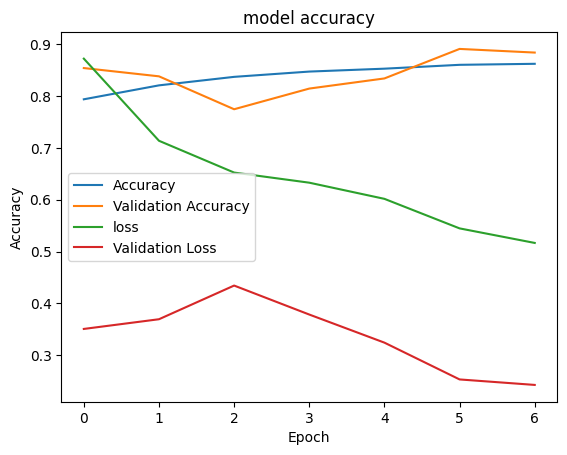

In [20]:
print(history.history.keys())
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "loss", "Validation Loss"])
plt.show()


In [22]:
resnet_model.summary()
#url = "D:/downloads/HAM10000_images_part_1/ISIC_0027315.jpg"
#url = "D:/downloads/HAM10000_images_part_1/ISIC_0024698.jpg"
# url = "D:/downloads/HAM10000_images_part_1/ISIC_0029081.jpg"
#img = cv2.imread(url)
# img = cv2.resize(cv2.imread(url), (256 , 256 )).reshape((256,256,3))
#print(img)
# l = np.array([img])
#l = np.expand_dims(img, axis=0)
# print(l)
#img1 = cv2.imread(l)
# result = resnet_model.predict(l)
# print(result)
# print(np.argmax(result))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 254)               520446    
                                                                 
 dense_1 (Dense)             (None, 128)               32640     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,141,056
Trainable params: 553,344
Non-trainable params: 23,587,712
_________________________________________________________________


In [23]:
new_model = tf.keras.models.load_model('first/future-feri-30-01-2023.hdf5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 254)               520446    
                                                                 
 dense_1 (Dense)             (None, 128)               32640     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,141,056
Trainable params: 553,344
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
print("Generate predictions")
predictions = new_model.predict(valid_gen, batch_size=128)
print("predictions shape:", predictions.shape)

Generate predictions
192/192 [==============================] - 558s 3s/step
predictions shape: (6142, 2)


In [25]:
print(len(predictions[0]))
values = np.argmax(predictions, axis=1)
values

2


array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [32]:
labels_valid = np.array(valid_data[:,1], dtype='int64')

In [62]:
malign_indexes_test_values = [i for i in range(len(valid_data)) if valid_data[i,1] == 1]
print('malign length from test data ' + str(len(malign_indexes_test_values)))
malign_indexes_prediction_values = [i for i in malign_indexes_test_values if values[i] == 1]
print('malign length from predictions data ' + str(len(malign_indexes_prediction_values)))
print('malign accuracy ' + str(len(malign_indexes_prediction_values) / len(malign_indexes_test_values)))

benign_indexes_test_values = [i for i in range(len(valid_data)) if valid_data[i,1] == 0]
print('benign length from test data ' + str(len(benign_indexes_test_values)))
benign_indexes_prediction_values = [i for i in benign_indexes_test_values if values[i] == 0]
print('benign length from predictions data ' + str(len(benign_indexes_prediction_values)))
print('benign accuracy ' + str(len(benign_indexes_prediction_values) / len(benign_indexes_test_values)))

malign length from test data 233
malign length from predictions data 196
malign accuracy 0.8412017167381974
benign length from test data 5909
benign length from predictions data 5275
benign accuracy 0.8927060416314098


In [44]:
from sklearn.metrics import classification_report

print(classification_report(labels_valid, values, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      5909
           1       0.24      0.84      0.37       233

    accuracy                           0.89      6142
   macro avg       0.61      0.87      0.65      6142
weighted avg       0.96      0.89      0.92      6142



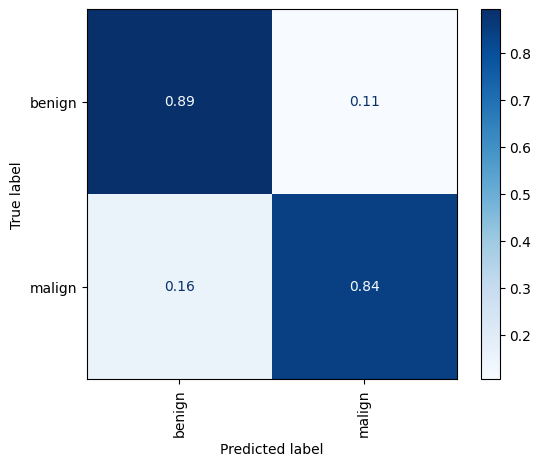

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# plt.rcParams['figure.figsize'] = [20, 20]
# plt.rcParams['figure.dpi'] = 100
cm = confusion_matrix(labels_valid, values, normalize='true',)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign','malign'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90) 
plt.savefig('confusion1.png')